In [1]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="whitegrid")
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")
import matplotlib.collections as clt
import matplotlib.patches as mpatches
import pickle

"""
This script generates the distribution plots from the paper. It begins with some data wrangling to get the data in the right format.
"""

'\nThis script generates the distribution plots from the paper. It begins with some data wrangling to get the data in the right format.\n'

In [2]:
# import medians
medians = pd.read_csv('../results/country_median_results.csv')
medians.loc[medians['Entity'] == 'Global', 'region'] = 'Global'

# calculate unpiped pop by region
medians["population_unpiped"] = medians["country_pop_with_water"] - medians["population_piped_with_access"]

# calculate global pop unpiped as sum of all rows except global
medians.loc[medians['Entity'] == 'Global', 'population_unpiped'] = medians.loc[medians['Entity'] != 'Global', 'population_unpiped'].sum()

# calculate region data
medians_unpiped = medians.groupby('region').apply(lambda x: x['population_unpiped'].sum() / x['country_pop_raw'].sum() * 100)
medians_no_access = medians.groupby('region').apply(lambda x: x['country_pop_without_water'].sum() / x['country_pop_raw'].sum() * 100)
medians_walk_access = medians.groupby('region').apply(lambda x: x['population_piped_with_walking_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_bike_access = medians.groupby('region').apply(lambda x: x['population_piped_with_only_cycling_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_undefined = 100 - medians_no_access - medians_walk_access - medians_bike_access - medians_unpiped

medians_regions = pd.DataFrame(
    {
        'region': medians_no_access.index,
        'no_access': medians_no_access.values,
        'walk_access': medians_walk_access.values,
        'bike_access': medians_bike_access.values,
        'unpiped': medians_unpiped.values,
        'undefined': medians_undefined.values,
    }
)

# set index to regions
medians_regions.set_index('region', inplace=True)

order = ['Oceania', 'Asia', 'Africa', 'Global', 'Europe', 'Americas']
medians_regions = medians_regions.reindex(order)

medians_regions

,no_access,walk_access,bike_access,unpiped,undefined
region,,,,,
Oceania,18.842885,42.843332,13.775922,23.322240,1.215621
Asia,21.305426,27.848702,12.195356,38.450234,0.200281
Africa,22.723770,13.905996,2.929919,60.362737,0.077578
Global,24.336476,28.239698,12.007999,35.586329,-0.170502
Europe,24.631712,47.359050,19.057769,8.599906,0.351563
Americas,39.160831,32.884967,18.105087,9.697708,0.151408


In [3]:
# import medians and CIs for no access
# Read country-level results from Monte Carlo sims

country_medians = pd.read_csv("../results/country_median_results.csv")
country_means = pd.read_csv("../results/country_mean_results.csv")
country_5th_percentiles = pd.read_csv("../results/country_5th_percentile_results.csv")
country_95th_percentiles = pd.read_csv("../results/country_95th_percentile_results.csv")

# Define a function to calculate percent without water
def calculate_percent(df, group):
    df.loc[df['Entity'] == 'Global', 'region'] = 'Global'
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})


# Print results
print(region_percent_without_water.sort_values(by='median', ascending=False))

             median  5th_percentile  95th_percentile
region                                              
Americas  39.160831       24.643488        54.156611
Europe    24.631712       10.703292        42.259806
Global    24.336476       14.394360        34.798312
Africa    22.723770       15.332949        30.016683
Asia      21.305426       12.202332        31.483891
Oceania   18.842885        9.012987        32.174270


In [4]:
with open('../results/countries_simulation_results.pkl', 'rb') as f:
    results = pickle.load(f)

for df in results:
    df.loc[df['Entity'] == 'Global', 'region'] = 'Global'

region_total_access = [
    df.groupby('region').apply(lambda x: x['country_pop_with_water'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_walk_access = [
    df.groupby('region').apply(lambda x: x['population_piped_with_walking_access'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_no_access = [
    df.groupby('region').apply(lambda x: x['country_pop_without_water'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_bike_access = [
    df.groupby('region').apply(lambda x: x['population_piped_with_only_cycling_access'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_unpiped = [
    df.groupby('region').apply(lambda x: x['country_pop_with_water'].sum() - x["population_piped_with_access"].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

# Create list of DataFrames with the results
region_dfs = [
    pd.DataFrame({
        'region': no_access_df.index,
        'total_access': total_access_df.values,
        'no_access': no_access_df.values,
        'walk_access': walk_access_df.values,
        'bike_access': bike_access_df.values,
        'unpiped': unpiped_df.values,
    })
    for no_access_df, total_access_df, walk_access_df, bike_access_df, unpiped_df in zip(region_no_access, region_total_access, region_walk_access, region_bike_access, region_unpiped)
]

In [5]:
# Pull out no access data
df = pd.concat(region_dfs, ignore_index=True)
df_melt = pd.melt(df, id_vars=['region'], value_vars=['no_access', 'walk_access', 'bike_access'])
no_access = df_melt[df_melt['variable'] == 'no_access']

no_access

,region,variable,value
0,Africa,no_access,22.854741
1,Americas,no_access,42.418349
2,Asia,no_access,22.771731
3,Europe,no_access,25.493423
4,Global,no_access,25.636739
...,...,...,...
5995,Americas,no_access,42.395281
5996,Asia,no_access,24.875106
5997,Europe,no_access,31.756845
5998,Global,no_access,28.273781


In [6]:
order = ['Oceania', 'Asia', 'Africa', 'Global', 'Europe', 'Americas']

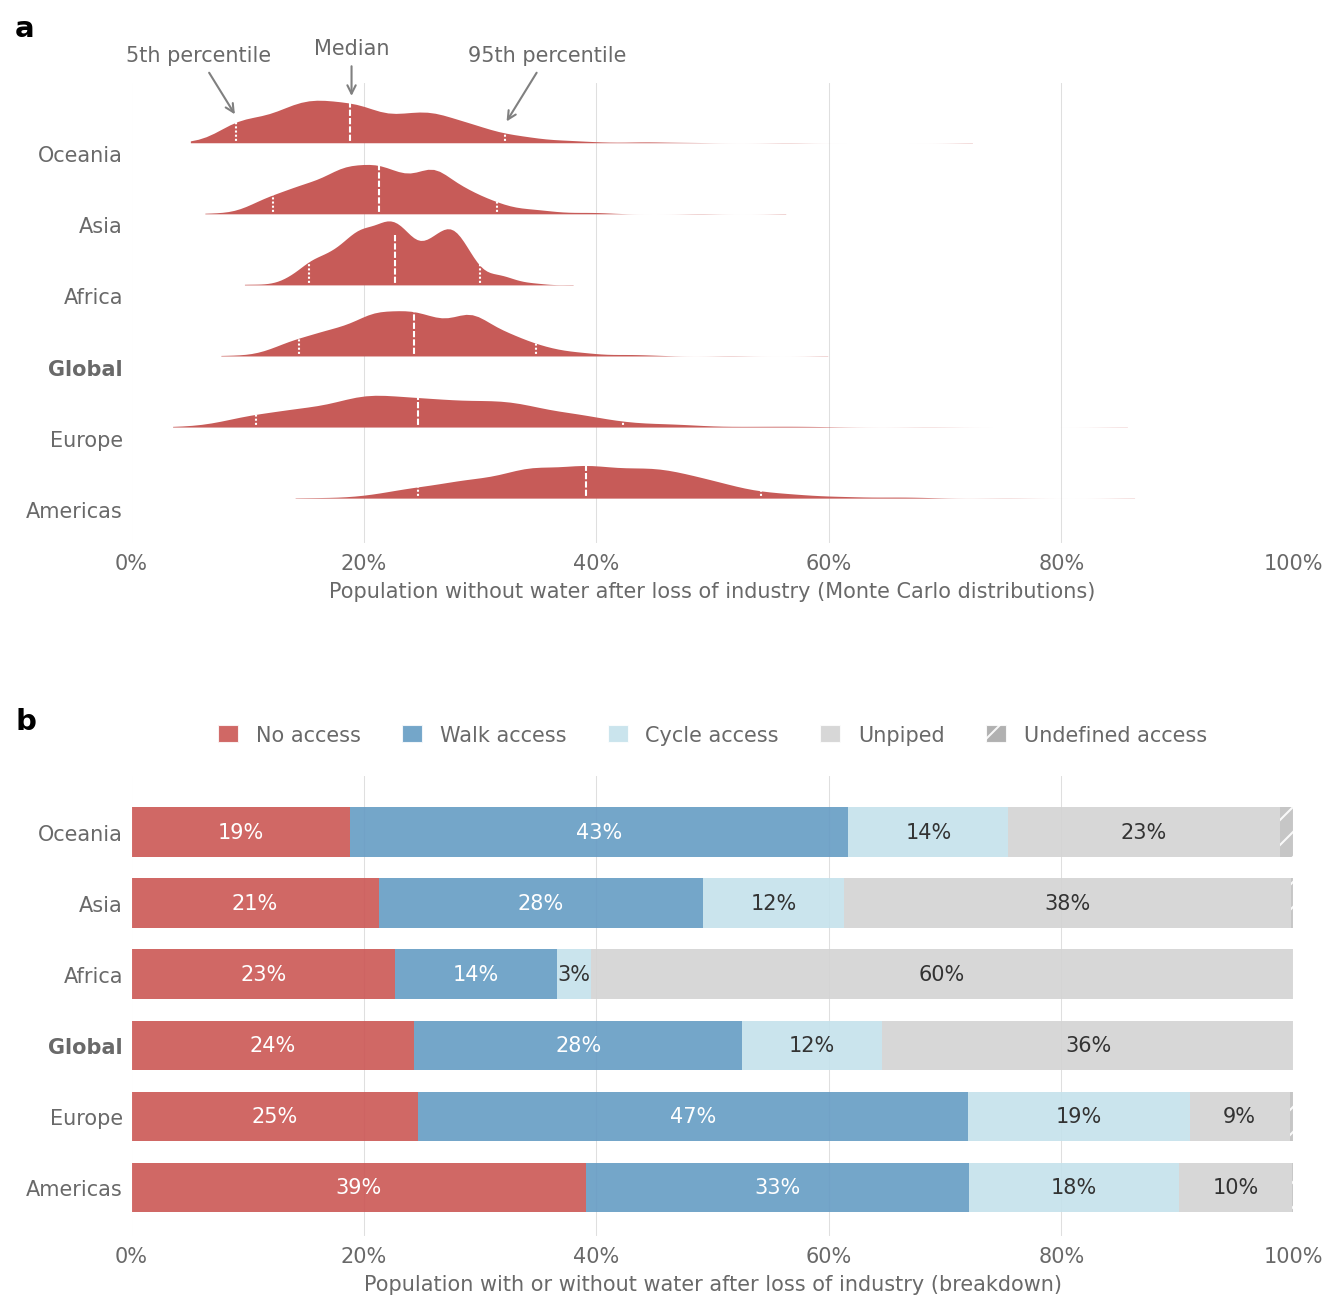

In [9]:
# plotting the clouds
# remove lines
# sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), sharex=False)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)

############# TOP PLOT ###################

dy="region"; dx="value"; ort="h"

pt.half_violinplot(
    x = dx,
    y = dy, 
    data = no_access,
    ax=ax1,
    palette = sns.color_palette(["#da4945"], desat=1),
    # palette = sns.color_palette(["#e91b0d"], desat=1),
    alpha=1,
    order=order,
    bw = 0.2, 
    cut = 0.,
    scale = "area",
    width = 1.8,
    inner = None,
    orient = ort,
    linewidth=0,
    # fix x axis 0-100
    )

# Extract the median and quantiles from region_percent_without_water
medians = region_percent_without_water['median']
quantile_5 = region_percent_without_water['5th_percentile']
quantile_95 = region_percent_without_water['95th_percentile']

# Add lines for the median and quantiles
violin_width = 0.7  # Adjust this value based on the width of your violin plots
shift = -0.5  # Adjust this value based on how much you want to shift the lines up
for i, region in enumerate(order):
    median = medians[region]
    q5 = quantile_5[region]
    q95 = quantile_95[region]
    ax1.plot([median, median], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (3, 1)))
    ax1.plot([q5, q5], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))
    ax1.plot([q95, q95], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))


############## BOTTOM PLOT #####################

medians_regions = medians_regions.reindex(order)
bars = medians_regions.plot.barh(
      stacked=True, 
      ax=ax2, 
      alpha=0.9,
      width=0.7,
      legend=False,
    #   color=['#DA291C', '#004680', '#3D87CB', '#75787B', 'silver'],
      color=['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'silver'],
      linewidth=0,
      edgecolor='white',
      )

# Apply hatching to the last category
patterns = [''] * 24 + ['//'] * 6

for bar, pattern in zip(bars.patches, patterns):
     bar.set_hatch(pattern)

count=0
label_color = "white"
for container in ax2.containers[:-1]:
    if count > 1:
        label_color = "#333333"
    ax2.bar_label(container, label_type="center", fmt="%.0f%%", fontsize=10, color=label_color)
    count += 1


############## STYLING #####################

# Remove the "region" label
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('Population without water after loss of industry (Monte Carlo distributions)')
ax2.set_xlabel('Population with or without water after loss of industry (breakdown)')

# Define the labels, colors, and hatches for the legend
labels = ['No access', 'Walk access', 'Cycle access', 'Unpiped', 'Undefined access']
# colors = ['#DA291C', '#004680', '#3D87CB', '#75787B', 'silver']
colors = ['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'darkgrey']
hatches = ['', '', '', '', '//']  # Add hatching to the last category

# Create a list of patches for the legend
patches = []
for label, color, hatch in zip(labels, colors, hatches):
    patch = mpatches.Patch(facecolor=color, edgecolor='white', hatch=hatch, label=label, alpha=0.9)
    patches.append(patch)

# Add the legend to the top of the plot
ax2.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(patches), frameon=False, handleheight=1.0, handlelength=1.0)


# Make the "Global" label bold
for label in ax1.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

for label in ax2.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels as percentages
def to_percent(x, position):
    return f'{int(x)}%'

# Create a formatter
formatter = FuncFormatter(to_percent)

# # Set the formatter for the x-axis
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim(len(medians_regions.index) - 0.5, -1)
ax2.set_ylim(len(medians_regions.index) - 0.3, -0.8)

# ax1.set_xlim(-20, 80)

plt.subplots_adjust(hspace=0.5)
ax2.yaxis.grid(False)

# Add labels to the subplots
ax1.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=14, weight='bold', color="black")
ax2.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=14, weight='bold', color="black")

ax1.annotate('Median', xy=(18.95, -0.75), xytext=(18.95, -1.4), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='center', color="dimgrey")

ax1.annotate('5th percentile', xy=(9.1, -0.5), xytext=(12, -1.3), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='right', color="dimgrey")

ax1.annotate('95th percentile', xy=(32.1, -0.4), xytext=(29, -1.3), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='left', color="dimgrey")

# save as 300 dpi png
plt.savefig('../results/access_distributions_allfed_colours.png', dpi=300)
plt.show()


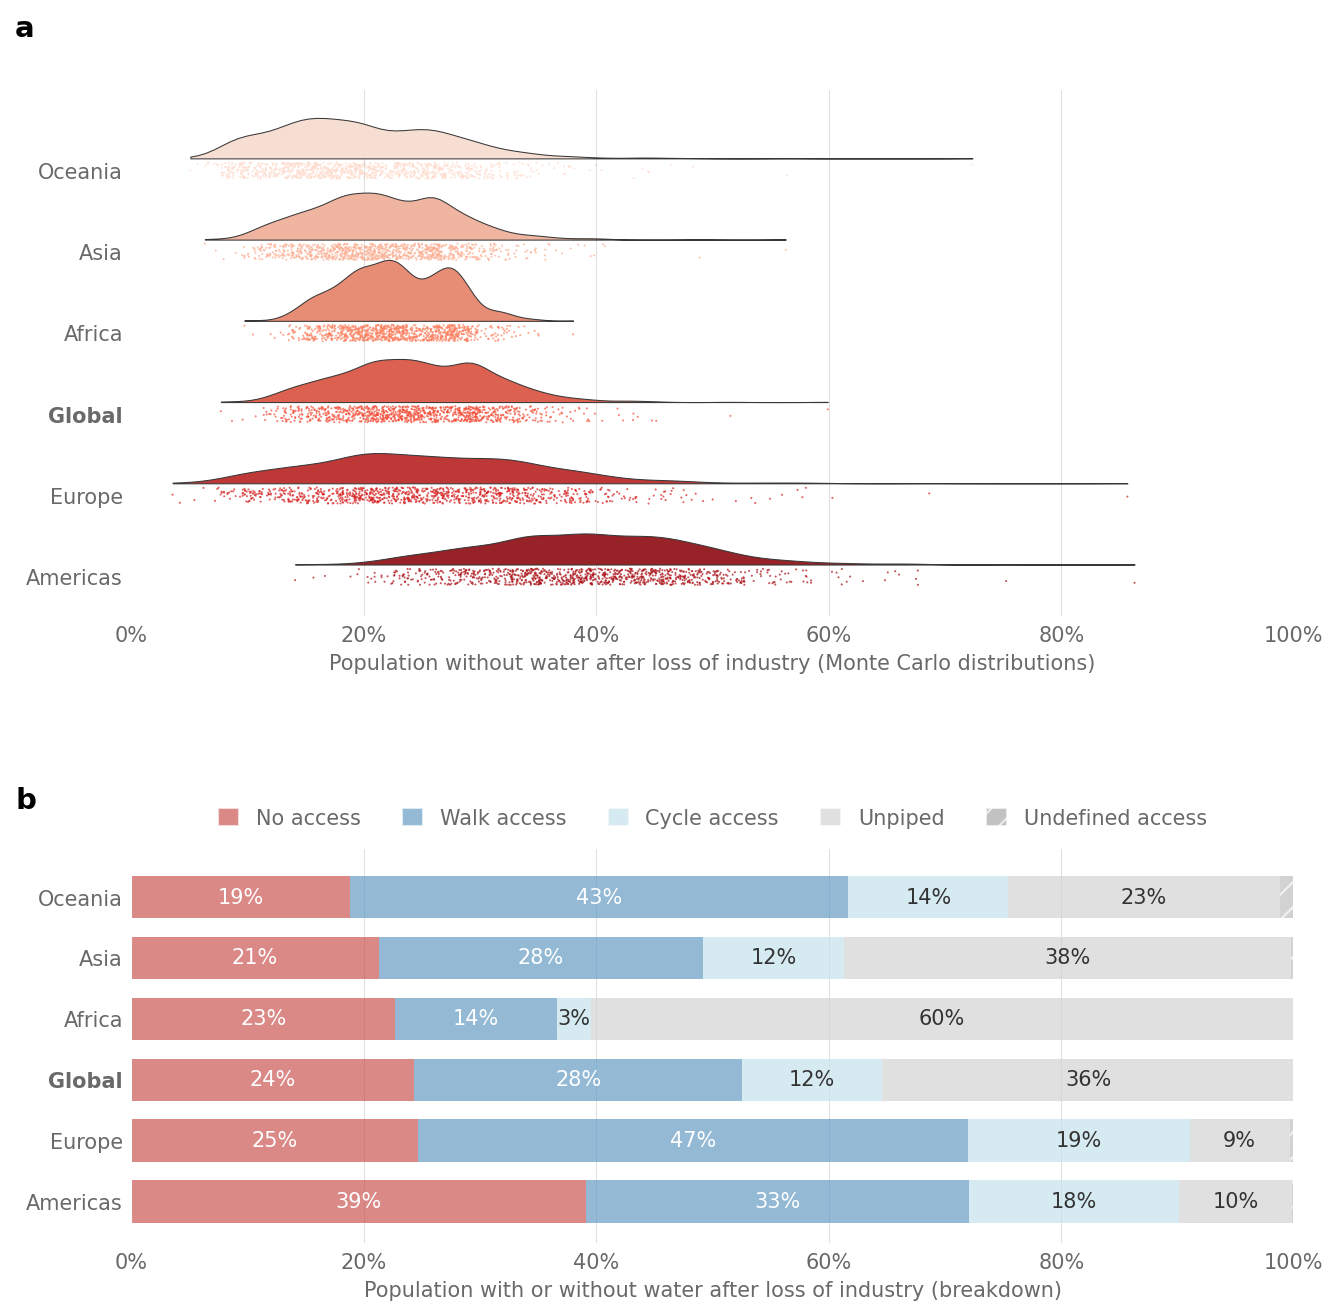

In [8]:
# plotting the clouds
# remove lines
# sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 3]}, sharex=False)
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)

############# TOP PLOT ###################

dy="region"; dx="value"; ort="h"; pal = sns.color_palette(n_colors=5)

pt.half_violinplot(
    x = dx,
    y = dy, 
    data = no_access,
    ax=ax1,
    palette = "Reds",
    #   palette = "Reds",
    order=order,
    bw = .2, 
    cut = 0.,
    scale = "area",
    width = 1.5,
    inner = None,
    orient = ort,
    linewidth=0.5,
    #fix x -100
    
    )

sns.stripplot(
    x=dx,
    y=dy,
    data=no_access,
    ax=ax1,
    palette="Reds",
    order=order,
    edgecolor="white",
    alpha=0.7,
    size=2,
    jitter=1,
    zorder=0,
    orient=ort
)


############## BOTTOM PLOT #####################

medians_regions = medians_regions.reindex(order)
bars = medians_regions.plot.barh(
      stacked=True, 
      ax=ax2, 
      alpha=0.7,
      width=0.7,
      legend=False,
    #   color=['firebrick', '#009688', 'mediumaquamarine', 'grey'],
    #   color=['#cb5754', '#659cc4', '#c5e2ec', '#feffab'],
      color=['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'silver'],
      linewidth=0,
      edgecolor='white',
      )

# Apply hatching to the last category
patterns = [''] * 24 + ['//'] * 6

for bar, pattern in zip(bars.patches, patterns):
     bar.set_hatch(pattern)

count=0
label_color = "white"
for container in ax2.containers[:-1]:
    if count > 1:
        label_color = "#333333"
    ax2.bar_label(container, label_type="center", fmt="%.0f%%", fontsize=10, color=label_color)
    count += 1


############## STYLING #####################

# Remove the "region" label
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('Population without water after loss of industry (Monte Carlo distributions)')
ax2.set_xlabel('Population with or without water after loss of industry (breakdown)')

# Define the labels, colors, and hatches for the legend
labels = ['No access', 'Walk access', 'Cycle access', 'Unpiped', 'Undefined access']
colors = ['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'darkgrey']
hatches = ['', '', '', '', '//']  # Add hatching to the last category

# Create a list of patches for the legend
patches = []
for label, color, hatch in zip(labels, colors, hatches):
    patch = mpatches.Patch(facecolor=color, edgecolor='white', hatch=hatch, label=label, alpha=0.7)
    patches.append(patch)

# Add the legend to the top of the plot
ax2.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(patches), frameon=False, handleheight=1.0, handlelength=1.0)


# Make the "Global" label bold
for label in ax1.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

for label in ax2.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels as percentages
def to_percent(x, position):
    return f'{int(x)}%'

# Create a formatter
formatter = FuncFormatter(to_percent)

# # Set the formatter for the x-axis
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim(len(medians_regions.index) - 0.5, -1)
ax2.set_ylim(len(medians_regions.index) - 0.3, -0.8)

plt.subplots_adjust(hspace=0.5)
ax2.yaxis.grid(False)

# Add labels to the subplots
ax1.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=14, weight='bold', color="black")
ax2.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=14, weight='bold', color="black")


plt.show()
